In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import itertools

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import torch
from torch import nn

In [3]:
import geopandas as gpd

In [4]:
from functions import *
from data_preprocess import *
from models import *
from train_loops import *
from raw_data import *

# Global Variables

In [5]:
wd = 1
iterations=10001
lrs = [1e-10, 1e-7]
lrs_gravrad = [1e-7, 1e-4]
params_init = [0., 0., 0., 0., 0., 0.]
coeff = coeff5

n_distributions = 2

In [6]:
#pre-process data
list_nums = [log_misuse, log_primary, log_workforce, log_knifecrime, 
             log_gdhi]
nums = []
for num in list_nums:
    if 'City of London' in num.columns:
        nums.append(num.T.sort_index().drop(index=['City of London', 
                                           'Metropolitan Police']).T)
    else:
        nums.append(num.T.sort_index().drop(index=['Metropolitan Police']).T)

pop = torch.Tensor(pop_2019['Pi'].sort_index().drop(index=['City of London', 
                                               'Metropolitan Police']))
times_tensor = torch.Tensor(times_London['cij'].sort_index().drop(index=['City of London', 'Metropolitan Police']))
Tis = torch.Tensor([data['2019'].sum(), data['2020'].sum()])

#pre-process targets
target = torch.cat((torch.Tensor(data['2019'].sort_index()), torch.Tensor(data['2020'].sort_index())))
M_0 = len(target)

target_gravrad = torch.Tensor(data['2019'].values)
M_1 = len(target_gravrad)

#cross-validation
n_folds = 2
names_cv = [np.linspace(0, M_1-1, M_1).astype('int'), 
            np.linspace(M_1, M_0-1, M_0-M_1).astype('int')]

#loss arrays
S_retail = np.zeros((n_distributions, len(coeff), n_folds))
S_radial = np.zeros((n_distributions, n_folds))
S_gravity = np.zeros((n_distributions, n_folds))

BIC_retail = np.zeros((n_distributions, len(coeff), n_folds))
BIC_radial = np.zeros((n_distributions, n_folds))
BIC_gravity = np.zeros((n_distributions, n_folds))

#parameters

prediction_parameters_retail = np.zeros((n_distributions, n_folds, len(coeff), len(list_nums)+1))
prediction_parameters_radial = np.zeros((n_distributions, n_folds, 2))
prediction_parameters_gravity = np.zeros((n_distributions, n_folds, 2))

In [7]:
#training loops
for (d, distribution) in enumerate(['Gauss', 'Poisson']):
    print('Retail', distribution)
    for (idx_c, c) in enumerate(coeff):
        print(c)
        k = sum(c)+1
        print('Retail')
        for fold in range(n_folds):
            idx = [i for i in range(M_0) if i not in names_cv[fold]]

            params_retail, losses_retail = train_loop_retail2(target[idx], 
                                 nums, Tis, pop_London, times_tensor, 
                                 names_cv[fold], c, distribution, params_init,
                                 lr=lrs[1], iterations=iterations, wd=wd, print_=False)

            idx_min = np.where(losses_retail==min(losses_retail[-100:]))[0][-1]
            alphas = params_retail[:-1, idx_min]
            beta = params_retail[-1, idx_min]

            prediction = retail2(alphas, beta,
                               Tis, pop_London, times_tensor, nums, idx)
            
            prediction_parameters_retail[d, fold, idx_c, :-1] = alphas
            prediction_parameters_retail[d, fold, idx_c, -1] = beta
            
            if distribution == 'Poisson':
                log_L = log_poisson(target[names_cv[fold]], prediction)
            elif distribution == 'Gauss':
                log_L = log_gauss(target[names_cv[fold]], prediction)

            bic = BIC(k, log_L)
            BIC_retail[d, idx_c, fold] = bic.item()

            S = sorensen(target[names_cv[fold]], prediction)
            S_retail[d, idx_c, fold] = S.item()
            
    ##lr and target
    
    #Number of free paramters for Radial and Gravity
    k = 2
    
    print('Radial', distribution)
    for fold in range(n_folds):
        idx = [i for i in range(M_0) if i not in names_cv[fold]]

        params_radial, losses_radial = train_loop_radial(target[idx], pop, pop_London, Tis, S_ij, wd, distribution, 
                                                    names_cv[fold],
                                                    print_=False, iterations=10000, lr=lrs_gravrad[d], alpha=1, n=1)
        
        idx_min = np.where(losses_radial==min(losses_radial[-100:]))[0][-1]
        alpha = params_radial[0, idx_min]
        n = params_radial[1, idx_min];

        idx_19 = [i for i in idx if i < M_1]
        idx_20 = [i-M_1 for i in idx if i not in idx_19]
        
        prediction_19 = radial_modified(Tis[0], alpha, n, pop, pop_London, S_ij, idx_19)
        prediction_20 = radial_modified(Tis[1], alpha, n, pop, pop_London, S_ij, idx_20)
        prediction = torch.cat([prediction_19, prediction_20])

        prediction_parameters_radial[d, fold, 0] = alpha
        prediction_parameters_radial[d, fold, 1] = n
        
        if distribution == 'Poisson':
            log_L = log_poisson(target[names_cv[fold]], prediction)
        elif distribution == 'Gauss':
            log_L = log_gauss(target[names_cv[fold]], prediction)

        bic = BIC(k, log_L)
        BIC_radial[d, fold] = bic.item()
        
        S = sorensen(target[names_cv[fold]], prediction)
        S_radial[d, fold] = S.item()

    print('Gravity', distribution)
    for fold in range(n_folds):
        idx = [i for i in range(M_0) if i not in names_cv[fold]]

        params_gravity, losses_gravity = train_loop_gravity(target[idx], pop, d_Lj[:-4], Tis, wd, distribution,
                                                     names_cv[fold],
                                                    print_=False, iterations=10000, beta=0.6, gamma=1., lr=lrs_gravrad[d])
        
        idx_min = np.where(losses_gravity==min(losses_gravity[-100:]))[0][-1]
        beta = params_gravity[0, idx_min]
        gamma = params_gravity[1, idx_min]
        
        idx_19 = [i for i in idx if i < M_1]
        idx_20 = [i-M_1 for i in idx if i not in idx_19]
        
        prediction_19 = gravity_modified(beta, gamma, Tis[0], pop, d_Lj[:-4], idx_19)
        prediction_20 = gravity_modified(beta, gamma, Tis[1], pop, d_Lj[:-4], idx_20)
        prediction = torch.cat([prediction_19, prediction_20])
        
        prediction_parameters_gravity[d, fold, 0] = beta
        prediction_parameters_gravity[d, fold, 1] = gamma
        
        if distribution == 'Poisson':
            log_L = log_poisson(target[names_cv[fold]], prediction)
        elif distribution == 'Gauss':
            log_L = log_gauss(target[names_cv[fold]], prediction)

        bic = BIC(k, log_L)
        BIC_gravity[d, fold] = bic.item()

        S = sorensen(target[names_cv[fold]], prediction)
        S_gravity[d, fold] = S.item()
        
print('End')

Retail Gauss
[0, 0, 0, 0, 0]
Retail
[1, 0, 0, 0, 0]
Retail
[0, 1, 0, 0, 0]
Retail
[0, 0, 1, 0, 0]
Retail
[0, 0, 0, 1, 0]
Retail
[0, 0, 0, 0, 1]
Retail
[1, 1, 0, 0, 0]
Retail
[1, 0, 1, 0, 0]
Retail
[1, 0, 0, 1, 0]
Retail
[1, 0, 0, 0, 1]
Retail
[0, 1, 1, 0, 0]
Retail
[0, 1, 0, 1, 0]
Retail
[0, 1, 0, 0, 1]
Retail
[0, 0, 1, 1, 0]
Retail
[0, 0, 1, 0, 1]
Retail
[0, 0, 0, 1, 1]
Retail
[1, 1, 1, 0, 0]
Retail
[1, 1, 0, 1, 0]
Retail
[1, 1, 0, 0, 1]
Retail
[1, 0, 1, 1, 0]
Retail
[1, 0, 1, 0, 1]
Retail
[0, 1, 1, 1, 0]
Retail
[0, 1, 1, 0, 1]
Retail
[0, 0, 1, 1, 1]
Retail
[0, 1, 0, 1, 1]
Retail
[1, 0, 0, 1, 1]
Retail
[1, 1, 1, 1, 0]
Retail
[1, 1, 1, 0, 1]
Retail
[1, 1, 0, 1, 1]
Retail
[1, 0, 1, 1, 1]
Retail
[0, 1, 1, 1, 1]
Retail
[1, 1, 1, 1, 1]
Retail
Radial Gauss
Gravity Gauss
Retail Poisson
[0, 0, 0, 0, 0]
Retail
[1, 0, 0, 0, 0]
Retail
[0, 1, 0, 0, 0]
Retail
[0, 0, 1, 0, 0]
Retail
[0, 0, 0, 1, 0]
Retail
[0, 0, 0, 0, 1]
Retail
[1, 1, 0, 0, 0]
Retail
[1, 0, 1, 0, 0]
Retail
[1, 0, 0, 1, 0]
Retail
[1

# Analysis Sorensen

In [8]:
S = np.zeros((n_distributions*(2+len(coeff)), n_folds))
S[:2, :] = S_gravity
S[2:4, :] = S_radial
S[4:4+len(coeff), :] = S_retail[1, :, :]
S[4+len(coeff):, :] = S_retail[0, :, :]

In [11]:
Y = np.zeros((len(coeff)+4, n_folds))
Y[:2, :] = S_gravity
Y[2:4, :] = S_radial
Y[4:4+len(coeff), :] = S_retail[1, :, :]

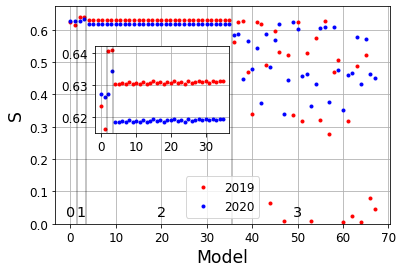

In [81]:
fig, ax = plt.subplots(1,1)

plt.plot(S[:, 1], 'r.', label='2019')
plt.plot(S[:, 0], 'b.', label='2020')

#plt.plot(S.mean(axis=1)[:], 'k+', alpha=0.4)
plt.grid()
plt.xlabel('Model', size='xx-large')
plt.ylabel('S', size='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')

alpha=0.3
#plt.yscale('log')
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)
plt.axvline(4+len(coeff)-0.5, color='k', alpha=alpha)

plt.ylim(ymin=0.)
plt.annotate('0', (-1, 0.025), fontsize='x-large')
plt.annotate('1', (1.3, 0.025), fontsize='x-large')
plt.annotate('2', (19, 0.025), fontsize='x-large')
plt.annotate('3', (49, 0.025), fontsize='x-large')


axins = inset_axes(ax, width="40%", height="40%", loc=2, borderpad=4)
axins.plot(S[:36, 0], 'b.')
axins.plot(S[:36, 1], 'r.')

plt.grid()

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

#plt.ylim(ymin=0.61)
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)


plt.savefig('Sorensen3.pdf', format='pdf', bbox_inches='tight')

In [15]:
sorted_S = [(position, S) for (position, S) in enumerate(np.concatenate([S[:, 0], S[:, 1]]))]
sorted_ = sorted(sorted_S, reverse=True, key=lambda tup: tup[1])[:10]

for i in range(10):
    s = sorted_[i][0]
    if s >= 4+len(coeff):
        s = s-(4+len(coeff))
        string_s = '{}-2'.format(s)
    else:
        string_s = '{}-1'.format(s)
    print((string_s, sorted_[i][1]))

('35-2', 0.6408362984657288)
('34-2', 0.6405370235443115)
('3-1', 0.6345066428184509)
('62-2', 0.6312422752380371)
('67-2', 0.6312422752380371)
('53-2', 0.6312333941459656)
('64-2', 0.631233274936676)
('57-2', 0.6312122941017151)
('66-2', 0.6312121748924255)
('47-2', 0.631203293800354)


# Analysis BIC

In [16]:
BICs = np.zeros((n_distributions*(2+len(coeff)), n_folds))
BICs[:2, :] = BIC_gravity
BICs[2:4, :] = BIC_radial
BICs[4:4+len(coeff), :] = BIC_retail[1, :, :]
BICs[4+len(coeff):, :] = BIC_retail[0, :, :]

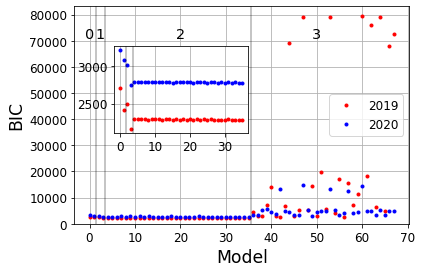

In [80]:
fig, ax = plt.subplots(1, 1)

plt.plot(BICs[:, 1], 'r.', label='2019')
plt.plot(BICs[:, 0], 'b.', label='2020')

#plt.plot(BICs.mean(axis=1)[:], 'k+', alpha=0.4)
plt.grid()
plt.xlabel('Model', size='xx-large')
plt.ylabel('BIC', size='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')

alpha=0.3
#plt.yscale('log')
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)
plt.axvline(4+len(coeff)-0.5, color='k', alpha=alpha)

plt.ylim(ymin=0.)
plt.annotate('0', (-1, 71000), fontsize='x-large')
plt.annotate('1', (1.3, 71000), fontsize='x-large')
plt.annotate('2', (19, 71000), fontsize='x-large')
plt.annotate('3', (49, 71000), fontsize='x-large')


axins = inset_axes(ax, width="40%", height="40%", loc=2, borderpad=4)
axins.plot(BICs[:36, 0], 'b.')
axins.plot(BICs[:36, 1], 'r.')

plt.grid()

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

#plt.ylim(ymin=0.61)
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)


plt.savefig('BIC3.pdf', format='pdf', bbox_inches='tight')

In [22]:
n = 9
sorted_BIC = [(position, bic) for (position, bic) in enumerate(np.concatenate([BICs[:, 0], BICs[:, 1]]))]
sorted_ = sorted(sorted_BIC, reverse=True, key=lambda tup: -tup[1])[:n]

corridas_BIC = []
for i in range(n):
    s = sorted_[i][0]
    if s >= 4+2*len(coeff):
        s = s-(4+2*len(coeff))
        string_s = '{}-2'.format(s)
    else:
        string_s = '{}-1'.format(s)
    corridas_BIC.append(string_s)
    print((i+1, string_s, sorted_[i][1]))
    

(1, '3-2', 2150.807861328125)
(2, '21-2', 2279.990234375)
(3, '15-2', 2280.036376953125)
(4, '30-2', 2280.209716796875)
(5, '25-2', 2280.38525390625)
(6, '32-2', 2280.455322265625)
(7, '35-2', 2280.59326171875)
(8, '28-2', 2280.630859375)
(9, '34-2', 2280.85009765625)


- 0,1 gravity
- 2,3 radial
- 4:36 retail Poisson
- 37:68 retail Gauss

In [25]:
n = 20

sorted_S = [(position, S) for (position, S) in enumerate(np.concatenate([S[:, 0], S[:, 1]]))]
sorted_ = sorted(sorted_S, reverse=True, key=lambda tup: tup[1])[:n]

#corridas_S = []
for i in range(n):
    s = sorted_[i][0]
    if s >= 4+2*len(coeff):
        s = s-(4+2*len(coeff))
        string_s = '{}-2'.format(s)
    else:
        string_s = '{}-1'.format(s)
    #corridas_S.append(string_s)
    print((i+1, string_s, sorted_[i][1]))
    

(1, '3-2', 0.6408362984657288)
(2, '2-2', 0.6405370235443115)
(3, '3-1', 0.6345066428184509)
(4, '30-2', 0.6312422752380371)
(5, '35-2', 0.6312422752380371)
(6, '21-2', 0.6312333941459656)
(7, '32-2', 0.631233274936676)
(8, '25-2', 0.6312122941017151)
(9, '34-2', 0.6312121748924255)
(10, '15-2', 0.631203293800354)
(11, '28-2', 0.6312032341957092)
(12, '23-2', 0.6308583617210388)
(13, '33-2', 0.6308583617210388)
(14, '12-2', 0.6308493614196777)
(15, '29-2', 0.6308493614196777)
(16, '17-2', 0.6308279633522034)
(17, '27-2', 0.6308279037475586)
(18, '8-2', 0.6308189630508423)
(19, '19-2', 0.6308189034461975)
(20, '20-2', 0.6306180357933044)


# Predictions

In [299]:
costs = np.zeros(len(coeff)+4)
predictions = np.zeros((len(coeff)+4, len(target)))

ind_zeros = np.where(target!=0)[0]

#### Gravity
beta, gamma = prediction_parameters_gravity[0, 1, :]

prediction_19 = gravity_modified(beta, gamma, Tis[0], pop, d_Lj[:-4], [])
prediction_20 = gravity_modified(beta, gamma, Tis[1], pop, d_Lj[:-4], [])
prediction = torch.cat([prediction_19, prediction_20])

predictions[0, :] = prediction.detach().numpy()

p = (prediction[ind_zeros].log()-target[ind_zeros].log()).square().sum()/len(prediction[ind_zeros])
costs[0] = float(p)

beta, gamma = prediction_parameters_gravity[1, 1, :]

prediction_19 = gravity_modified(beta, gamma, Tis[0], pop, d_Lj[:-4], [])
prediction_20 = gravity_modified(beta, gamma, Tis[1], pop, d_Lj[:-4], [])
prediction = torch.cat([prediction_19, prediction_20])

predictions[1, :] = prediction.detach().numpy()

p = (prediction[ind_zeros].log()-target[ind_zeros].log()).square().sum()/len(prediction[ind_zeros])
costs[1] = float(p)

#### Radial
alpha, n = prediction_parameters_radial[0, 1,:]

prediction_19 = radial_modified(Tis[0], alpha, n, pop, pop_London, S_ij, [])
prediction_20 = radial_modified(Tis[1], alpha, n, pop, pop_London, S_ij, [])
prediction = torch.cat([prediction_19, prediction_20])

predictions[2, :] = prediction.detach().numpy()

p = (prediction[ind_zeros].log()-target[ind_zeros].log()).square().sum()/len(prediction[ind_zeros])
costs[2] = float(p)

alpha, n = prediction_parameters_radial[1, 1,:]

prediction_19 = radial_modified(Tis[0], alpha, n, pop, pop_London, S_ij, [])
prediction_20 = radial_modified(Tis[1], alpha, n, pop, pop_London, S_ij, [])
prediction = torch.cat([prediction_19, prediction_20])

predictions[3, :] = prediction.detach().numpy()

p = (prediction[ind_zeros].log()-target[ind_zeros].log()).square().sum()/len(prediction[ind_zeros])
costs[3] = float(p)

#### Retail

for i in range(len(coeff)):
    alphas = prediction_parameters_retail[1, 1, i, :-1]
    beta = prediction_parameters_retail[1, 1, i, -1]
    prediction = retail2(alphas, beta, Tis, pop_London, times_tensor, nums, [])

    predictions[4+i, :] = prediction.detach().numpy()
    
    p = (prediction[ind_zeros].log()-target[ind_zeros].log()).square().sum()/len(prediction[ind_zeros])
    costs[4+i] = float(p)

In [298]:
prediction[np.where(target!=0)[0]]

tensor([ 75.0550, 211.7674, 100.9652,  23.6648,  12.2532,   6.5506,  62.5938,
         29.3211,  67.8543, 234.9149,  81.5558,  20.9790, 140.2949, 231.0972,
         19.4333, 210.2751,  17.6112,  83.4369,  59.1086,  18.0741,  81.9787,
         19.0164, 127.3725,   7.9296,  49.2202,  40.0084,  46.7446, 102.6789,
        249.0302, 126.9557, 287.1296, 115.7421,  44.1030,  71.4894,  25.6901,
        115.9134,  63.3612, 179.0308,  85.0496,  19.9644,  10.4091,   5.5241,
         52.8690,  24.7849,  57.7951, 196.9083,  69.2215,  18.9338, 118.9575,
        194.8876,  16.4260, 177.8132,  14.9455,  70.5518,  50.2777,  15.2831,
         69.0233,  16.1642, 107.4162,   6.7467,  41.7631,  33.9090,  39.7715,
         86.2986, 210.6735, 107.1507, 242.9657,  97.9533,  37.1880,  61.0527,
         21.7915,  98.2969])

In [163]:
costs

array([7659.57324219, 8065.92480469,    0.        , 7013.83105469,
       8175.74853516, 8174.5703125 , 8160.94238281, 8175.15771484,
       8149.23828125, 8175.74658203, 8159.7734375 , 8173.97216797,
       8148.08886719, 8174.5703125 , 8160.34619141, 8134.75146484,
       8160.94189453, 8148.65527344, 8175.15625   , 8149.23486328,
       8159.18066406, 8133.61425781, 8159.77783203, 8147.5       ,
       8173.97021484, 8134.16699219, 8160.34375   , 8148.65185547,
       8134.74658203, 8148.08007812, 8133.03125   , 8159.17578125,
       8133.60888672, 8147.49658203, 8134.1640625 , 8133.02539062])

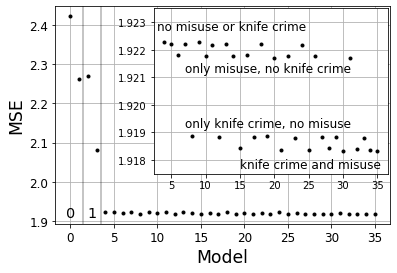

In [336]:
fig, ax = plt.subplots(1,1)

ax.plot(costs, 'k.')
plt.grid()
plt.xlabel('Model', size='xx-large')
plt.ylabel('MSE', size='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

alpha=0.3
#plt.yscale('log')
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)

#plt.ylim(ymin=6800)
plt.annotate('0', (-0.5, 1.91), fontsize='x-large')
plt.annotate('1', (2, 1.91), fontsize='x-large')
#plt.annotate('2', (19, 1.9), fontsize='x-large')

axins = inset_axes(ax, width="70%", height="76%", loc=1, borderpad=0.2)
axins.plot([i for i in range(4, 36)], costs[4:], 'k.')
plt.ylim(ymin=1.9175, ymax=1.9235)
plt.grid()

plt.annotate('no misuse or knife crime', (3, 1.9227), size='large')
plt.annotate('only misuse, no knife crime', (7, 1.9212), size='large')
plt.annotate('only knife crime, no misuse', (7, 1.9192), size='large')
plt.annotate('knife crime and misuse', (15, 1.9177), size='large')


plt.savefig('costs.pdf', format='pdf', bbox_inches='tight')

In [35]:
min_cost = min(costs[[11+2, 17+2, 21+2, 24+2, 26+2, 28+2, 30+2, 31+2]])

100*(costs[[11+2, 17+2, 21+2, 24+2, 26+2, 28+2, 30+2, 31+2]]-min_cost)/min_cost

array([2.12230275e-02, 7.24044447e-03, 1.40366162e-02, 2.11629907e-02,
       7.20442236e-05, 7.17440394e-03, 1.40005941e-02, 0.00000000e+00])

In [216]:
values19, indices19 = target[:int(len(target)/2)].sort()
values20, indices20 = target[int(len(target)/2):].sort()

In [38]:
chosen_models_retail = [11+2, 17+2, 21+2, 24+2, 26+2, 28+2, 30+2, 31+2]

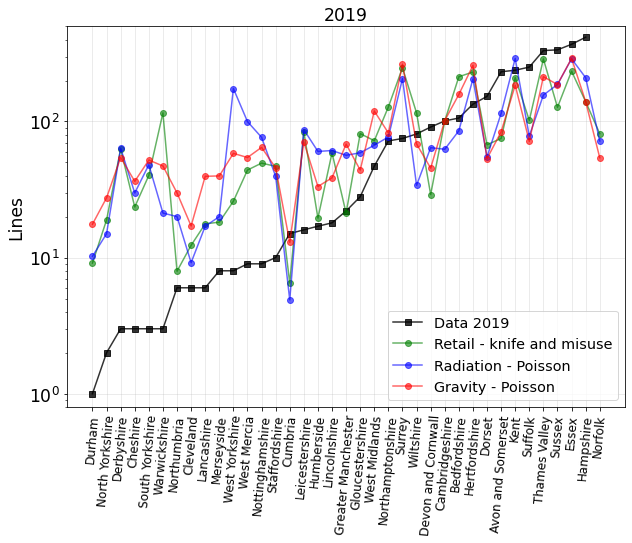

In [371]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(values19[1:], 'ks-', alpha=0.8, label='Data 2019')

alpha=0.6
ax.plot(predictions[11+3, indices19], 'go-', alpha=alpha, label='Retail - knife and misuse')
ax.plot(predictions[3, indices19], 'bo-', alpha=alpha, label='Radiation - Poisson')
ax.plot(predictions[1, indices19], 'ro-', alpha=alpha, label='Gravity - Poisson')
#ax.plot(predictions[8, indices19], 'go-', alpha=alpha, label='knife crime')
#ax.plot(predictions[6, indices19], 'mo-', alpha=alpha, label='misuse')
#ax.plot(predictions[24, indices19], 'ro-', alpha=alpha, label='no knife or misuse')

plt.legend(loc=4, fontsize='x-large')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.title('2019', size='xx-large')
plt.ylim(ymin=0.8, ymax=500)

plt.xticks(range(0, len(names)))
ax.set_xticklabels(names[indices19], rotation=85, size='large')

plt.ylabel('Lines', size='xx-large')
plt.yticks(size='xx-large')

plt.savefig('dispersion19.pdf', format='pdf', bbox_inches='tight')

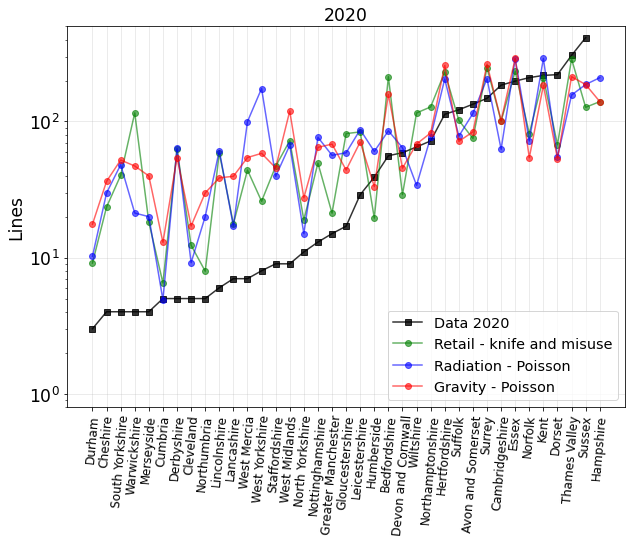

In [370]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(values20[1:], 'ks-', alpha=0.8, label='Data 2020')

alpha=0.6
ax.plot(predictions[11+3, indices20], 'go-', alpha=alpha, label='Retail - knife and misuse')
ax.plot(predictions[3, indices20], 'bo-', alpha=alpha, label='Radiation - Poisson')
#ax.plot(predictions[2, indices20], 'ro-', alpha=alpha, label='Radiation - Gauss')
#ax.plot(predictions[0, indices20], 'mo-', alpha=alpha, label='Gravity - Gauss')
ax.plot(predictions[1, indices20], 'ro-', alpha=alpha, label='Gravity - Poisson')

plt.legend(loc=4, fontsize='x-large')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.title('2020', size='xx-large')
plt.ylim(ymin=0.8, ymax=500)

plt.xticks(range(0, len(names)))
ax.set_xticklabels(names[indices20], rotation=85, size='large')

plt.ylabel('Lines', size='xx-large')
plt.yticks(size='xx-large')

plt.savefig('dispersion20.pdf', format='pdf', bbox_inches='tight')

# Maps

In [257]:
data_geo = gpd.read_file('police_areas.geojson')

In [258]:
data_geo.columns

Index(['OBJECTID', 'PFA19CD', 'PFA19NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [259]:
data_geo = data_geo[['PFA19NM', 'geometry']]
data_geo = data_geo.rename(columns={'PFA19NM': 'name'})
data_geo = data_geo.sort_values(by='name').reset_index(drop=True)

In [260]:
data_geo = data_geo.drop(index=[10, 14, 22, 24, 26, 31]).reset_index(drop=True)


In [278]:
df_predictions = pd.DataFrame([predictions[0, :37], predictions[0, 37:],
                               predictions[1, :37], predictions[1, 37:],
                               predictions[2, :37], predictions[2, 37:],
                               predictions[3, :37], predictions[3, 37:],
                               predictions[14, :37],
                               predictions[14, 37:]]).T

In [279]:
df_predictions.columns = ['GravityGauss2019', 'GravityGauss2020', 
                          'GravityPoisson2019', 'GravityPoisson2020', 
                          'RadiationGauss2019', 'RadiationGauss2020', 
                          'RadiationPoisson2019', 'RadiationPoisson2020', 
                          'RetailPoisson2019', 'RetailPoisson2020']

In [280]:
target19 = target.detach().numpy()[:37]
target20 = target.detach().numpy()[37:]

df_target = pd.DataFrame([target19, target20]).T
df_target.columns = ['Target2019', 'Target2020']

In [397]:
df_diff = pd.DataFrame(index=df_target.index)#, columns=[0])
for year in ['2019', '2020']:
    for model in ['Gravity', 'Retail', 'Radiation']:
        for function in ['Gauss', 'Poisson']:
            if model+function!='RetailGauss':
                df_dummy = pd.DataFrame(df_predictions[model+function+year]-df_target['Target'+year], 
                                        columns=['Diff '+model+function+year])
                df_diff = df_diff.join(df_dummy)

In [398]:
df = data_geo.join([df_predictions, df_target, df_diff])


In [283]:
df.columns

Index(['name', 'geometry', 'GravityGauss2019', 'GravityGauss2020',
       'GravityPoisson2019', 'GravityPoisson2020', 'RadiationGauss2019',
       'RadiationGauss2020', 'RadiationPoisson2019', 'RadiationPoisson2020',
       'RetailPoisson2019', 'RetailPoisson2020', 'Target2019', 'Target2020',
       'Diff GravityPoisson2019', 'Diff RadiationPoisson2019',
       'Diff GravityPoisson2020', 'Diff RadiationPoisson2020'],
      dtype='object')

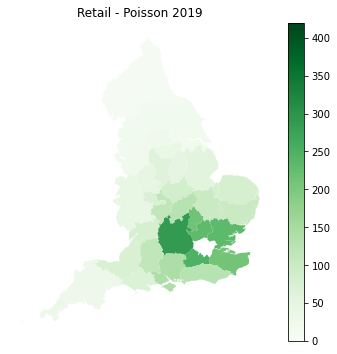

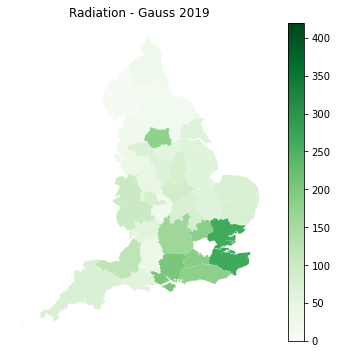

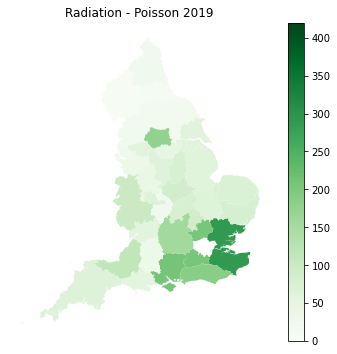

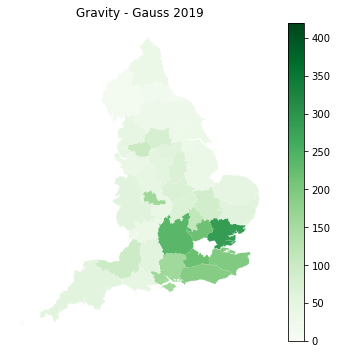

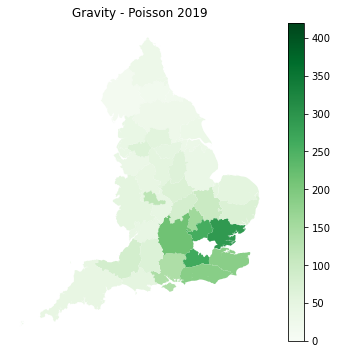

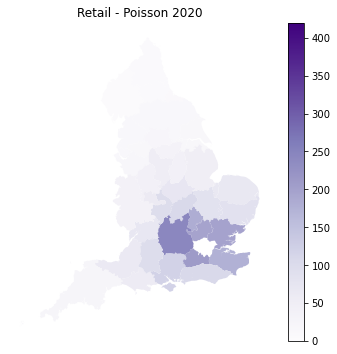

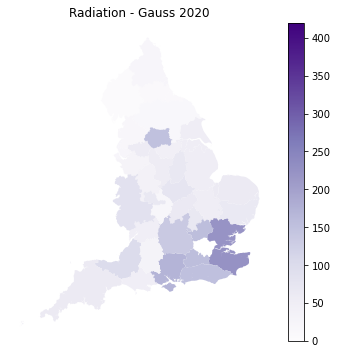

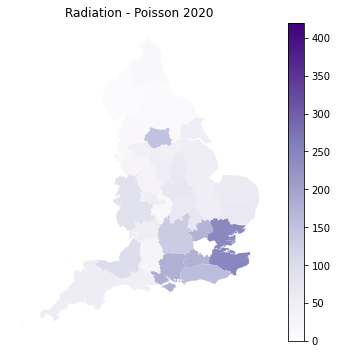

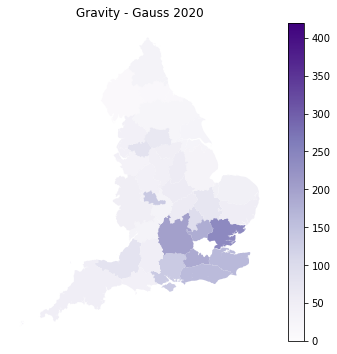

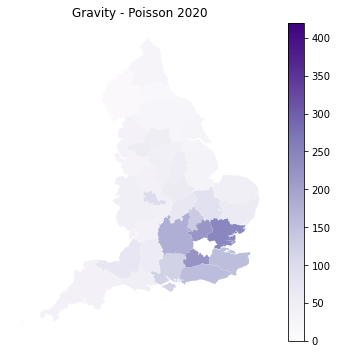

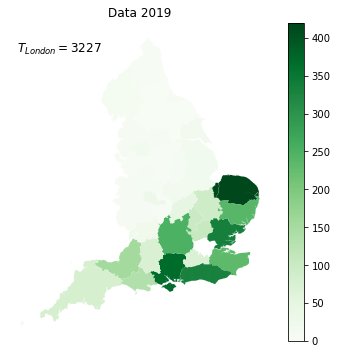

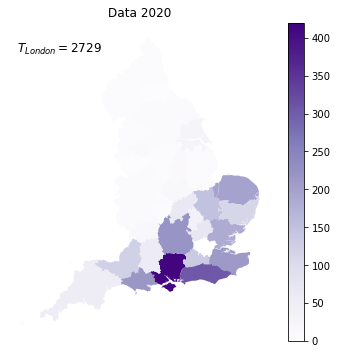

In [287]:
titles = ['Retail-Gravity 20', 'Retail police 20', 'Radiation 20', 'Data 20']

for year in ['2019', '2020']:
    for (i, col) in enumerate(['Retail', 'Radiation', 'Gravity']):
        for function in ['Gauss', 'Poisson']:
            if col+function!='RetailGauss':
                color = 'Greens' if year=='2019' else 'Purples'
                fig, ax = plt.subplots(1, 1, figsize=(5,5))
                df.plot(ax=ax, column=col+function+year, legend=True, vmin=0, vmax=420, cmap=color)
                ax.title.set_text(col+' - '+function+' '+year)
                ax.set_axis_off()
                fig.tight_layout()
                plt.savefig(col+function+year+'.png', format='png', bbox_inches='tight')
            
for year in ['2019', '2020']:
    color = 'Greens' if year=='2019' else 'Purples'
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    df.plot(ax=ax, column='Target'+year, legend=True, vmin=0, vmax=420, cmap=color)
    ax.title.set_text('Data '+year)
    ax.set_axis_off()
    Ti = data[year].sum()
    plt.annotate(text='$T_{London}=$'+str(Ti), xy=(-6.5, 55.5), size='large')
    fig.tight_layout()
    plt.savefig('Data'+year+'.png', format='png', bbox_inches='tight')

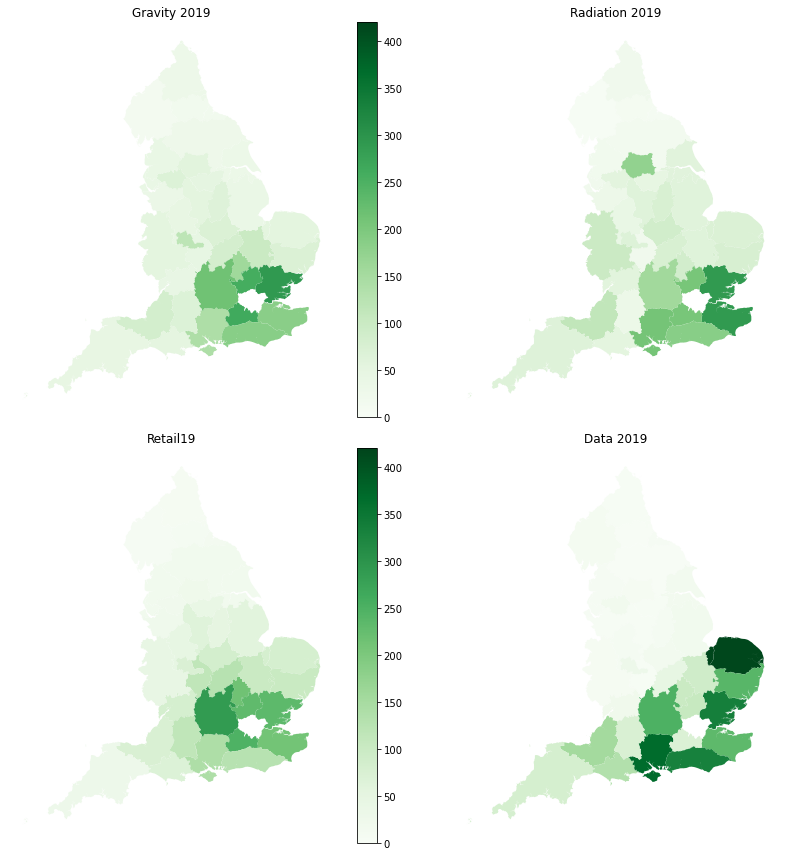

In [394]:
year='19'
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

minmax = 420 

p0 = df.plot(ax=ax[0, 0], column='GravityPoisson20'+year, legend=True, vmin=0, vmax=minmax, cmap='Greens')
p1 = df.plot(ax=ax[1, 0], column='RetailPoisson20'+year, legend=True, vmin=0, vmax=minmax, cmap='Greens')
p2 = df.plot(ax=ax[0, 1], column='RadiationPoisson20' +year, legend=False, vmin=0, vmax=minmax, cmap='Greens')
p3 = df.plot(ax=ax[1, 1], column='Target20'+year, legend=False, vmin=0, vmax=minmax, cmap='Greens')

ax[0,0].title.set_text('Gravity 20'+year)
ax[1,0].title.set_text('Retail'+year)
ax[0,1].title.set_text('Radiation 20'+year)
ax[1,1].title.set_text('Data 20'+year)

ax[0, 0].set_axis_off()
ax[1, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[1, 1].set_axis_off()

fig.tight_layout()

KeyError: 'Gravity 20'

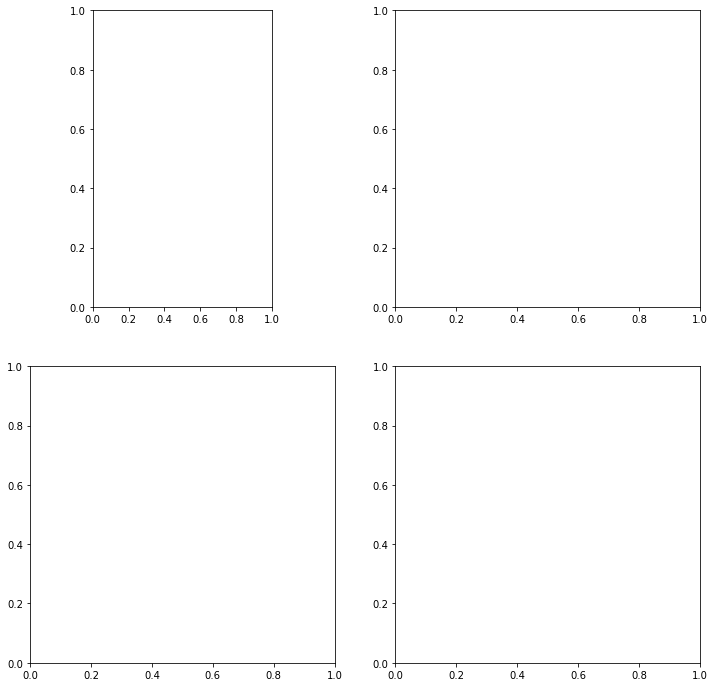

In [391]:
year='20'
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

minmax = 420 

p0 = df.plot(ax=ax[0, 0], column='GravityPoisson20'+year, legend=True, vmin=0, vmax=minmax, cmap='Greens')
p1 = df.plot(ax=ax[1, 0], column='RetailPoisson20'+year, legend=True, vmin=0, vmax=minmax, cmap='Greens')
p2 = df.plot(ax=ax[0, 1], column='RadialPoisson20' +year, legend=False, vmin=0, vmax=minmax, cmap='Greens')
p3 = df.plot(ax=ax[1, 1], column='Target20'+year, legend=False, vmin=0, vmax=minmax, cmap='Greens')

ax[0,0].title.set_text('Gravity 20'+year)
ax[1,0].title.set_text('Retail'+year)
ax[0,1].title.set_text('Radiation 20'+year)
ax[1,1].title.set_text('Data 20'+year)

ax[0, 0].set_axis_off()
ax[1, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[1, 1].set_axis_off()

fig.tight_layout()

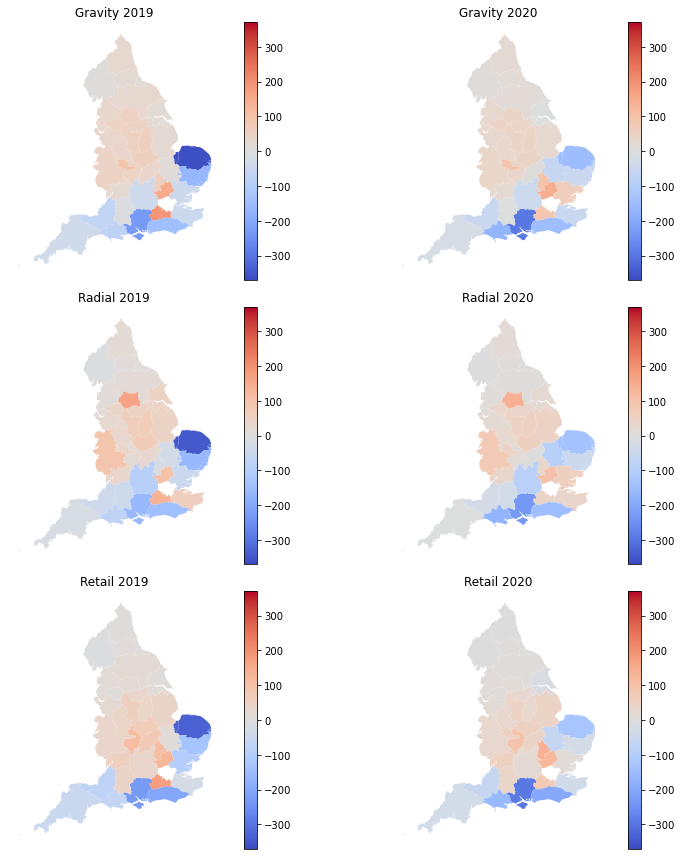

In [52]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

minmax = 370

p0 = df.plot(ax=ax[0, 0], column='Diff Gravity 19', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
p1 = df.plot(ax=ax[1, 0], column='Diff Radial 19', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
p2 = df.plot(ax=ax[2, 0], column='Diff Retail 19', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')

p3 = df.plot(ax=ax[0, 1], column='Diff Gravity 20', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
p4 = df.plot(ax=ax[1, 1], column='Diff Radial 20', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
p5 = df.plot(ax=ax[2, 1], column='Diff Retail 20', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')

ax[0,0].title.set_text('Gravity 2019')
ax[1,0].title.set_text('Radial 2019')
ax[2,0].title.set_text('Retail 2019')
ax[0,1].title.set_text('Gravity 2020')
ax[1,1].title.set_text('Radial 2020')
ax[2,1].title.set_text('Retail 2020')

ax[0, 0].set_axis_off()
ax[1, 0].set_axis_off()
ax[2, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[1, 1].set_axis_off()
ax[2, 1].set_axis_off()

fig.tight_layout()

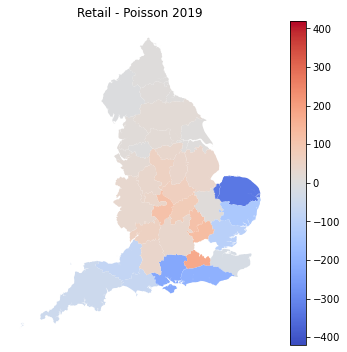

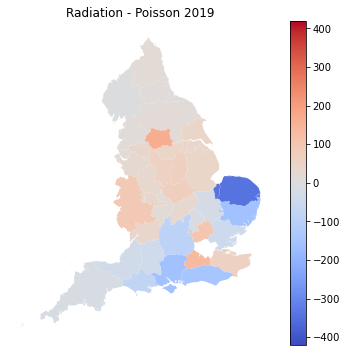

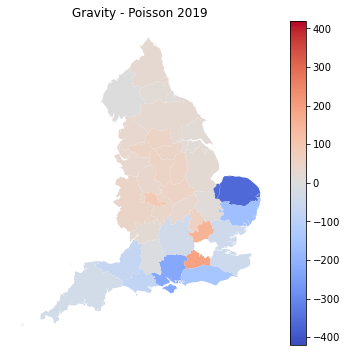

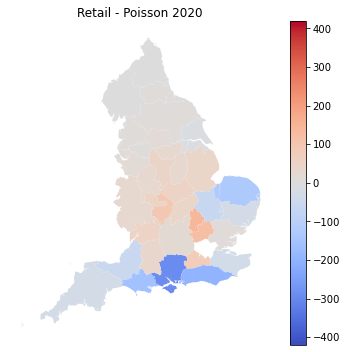

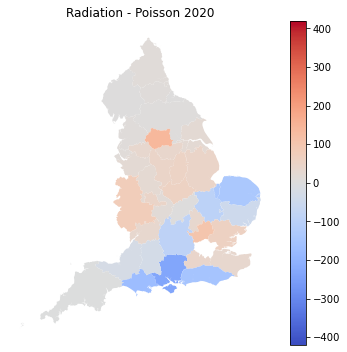

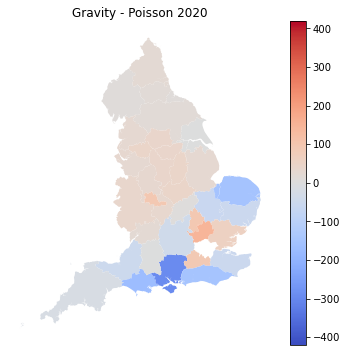

In [405]:
for year in ['2019', '2020']:
    for (i, col) in enumerate(['Retail', 'Radiation', 'Gravity']):
        function = 'Poisson'
        if col+function!='RetailGauss':
            color = 'Greens' if year=='2019' else 'Purples'
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            df.plot(ax=ax, column='Diff '+col+function+year, legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
            ax.title.set_text(col+' - '+function+' '+year)
            ax.set_axis_off()
            fig.tight_layout()
            plt.savefig('Diff'+col+function+year+'.png', format='png', bbox_inches='tight')
            